In [1]:
import csv
import tweepy
import pandas as pd
import re
import string
import nltk
import time
from nltk.corpus import words
from textblob import TextBlob
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer,TfidfTransformer
from sklearn import preprocessing

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Read the data from the file
df = pd.read_csv("/Users/sachinim/Documents/SDGP/Data Science Model/Twylist Telecom Dataset.csv" )

#dataset count
df.shape

(869, 4)

In [3]:
#Removing duplicate data
df = df.drop_duplicates(subset=None, keep='first', inplace=False)

In [4]:
df

,Unnamed: 0,Category,Label,text
0,0,Poor service,4,@VZWSupport Give me a working phone without ha...
1,1,Poor service,4,"@verizon, my daughter and I both have #Verizon..."
2,2,Poor service,4,Verizon customer service is the worst. I drea...
3,3,Happy Customer,2,I love having Verizon. I get service just abou...
4,4,Happy Customer,2,Great service from @VZWSupport and @SamsungSup...
...,...,...,...,...
864,864,Poor service,4,@verizon this is the second time the whole “cu...
865,865,Higher Price,3,@VZWNow as if my part of 3 people on my bill i...
866,866,Higher Price,3,@Ask_Spectrum I can call 2 days in a row and g...
867,867,Poor service,4,@verizon You don't have the best network. @TMo...


In [5]:
#This data set categorize for 4 types
# Happy Customer --> Positive
# Potential New Customer --> Neutral
# Lost Customer, Poor Service --> Negative

df['sentiment'] = ' '
for i,cat in enumerate(df.Category) :
    if cat=='Happy Customer' :
        df['sentiment'][i] = 'positive'
    elif cat=='Potential New Customer' :
        df['sentiment'][i] = 'neutral'
    else :
        df['sentiment'][i] = 'negative'
df.head()

<ipython-input-5-9bb58610efcc>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'][i] = 'negative'
<ipython-input-5-9bb58610efcc>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'][i] = 'positive'
<ipython-input-5-9bb58610efcc>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'][i] = 'neutral'


,Unnamed: 0,Category,Label,text,sentiment
0,0,Poor service,4,@VZWSupport Give me a working phone without ha...,negative
1,1,Poor service,4,"@verizon, my daughter and I both have #Verizon...",negative
2,2,Poor service,4,Verizon customer service is the worst. I drea...,negative
3,3,Happy Customer,2,I love having Verizon. I get service just abou...,positive
4,4,Happy Customer,2,Great service from @VZWSupport and @SamsungSup...,positive


In [6]:
words = set(nltk.corpus.words.words())

In [7]:
def text_lemmatizer(text):
  # This function is used to lemmatize the given sentence
    lemmatizer =  WordNetLemmatizer ()
    token_words = word_tokenize(text)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(lemmatizer.lemmatize(word))
    return " ".join(stem_sentence)

In [8]:
# Remove special characters from the tweet
def clean_text(tweet):
    
    tweet = tweet.lower()
    
    # have to remove "b'RT @endaburke81" at the begining of the tweet
    if(tweet[:4]=="b'rt"):
        tweet = tweet.split(":", 1)[1]

    # splitting the tweet
    tweet = tweet.split()
    
    # Joining the tweet
    tweet = " ".join(tweet)
    
    #Removing digits and numbers
    tweet = "".join([i for i in tweet if not i.isdigit()])
    
    # Removing special characters from the tweet
    tweet = re.sub(f'[{re.escape(string.punctuation)}]', "", tweet)
    
    # cleaning = nltk.tokenize.wordpunct_tokenize(tweet)
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) if w.lower() in words or not w.isalpha())
    
    tweet = text_lemmatizer(tweet)
    
    return tweet

In [9]:
#apply method of cleaning text
df["tweet_clean"] = df["text"].apply(clean_text)

In [10]:
# number of negative data = 632
df.loc[df['sentiment'] == "negative"].shape

(632, 6)

In [11]:
# number of positive data = 136
df.loc[df['sentiment'] == "positive"].shape

(136, 6)

In [12]:
# number of neutral data = 101
df.loc[df['sentiment'] == "neutral"].shape

(101, 6)

In [13]:
# split the data set
# 20% test, 80% train
x_train, x_test, y_train, y_test = train_test_split(df["tweet_clean"], df["sentiment"],test_size=0.2, random_state=123)

In [14]:
# Tokenize Words in each tweets (Encoding)
# TfidfVectorizer converts text to word frequency vectors

tfidf_vectorizer = TfidfVectorizer(tokenizer=word_tokenize, token_pattern=None)
tfidf_vectorizer.fit(df["tweet_clean"])
x_train_vector = tfidf_vectorizer.transform(x_train)
x_test_vector = tfidf_vectorizer.transform(x_test)

In [15]:
def evaluate_metrics(y_test, y_hat, model_type,time):
    
    accuracy = accuracy_score(y_hat, y_test)
    
    # Type of Algorithm
    print("Model Type : ", model_type)
    
    # Accuracy level
    print("\nAccuracy : ", format(accuracy, '.2f'))
    
    # Timing
    print("\nTraining Time : ", format(time, '.2f'), "s" )
    
    # Report Of Classification
    print("\n", classification_report(y_hat, y_test))

    # Creating Heat Map
    plt.figure(figsize=(10,6))
    sns.heatmap(confusion_matrix(y_hat, y_test), annot=True, fmt=".2f")
    plt.show()
    return accuracy

In [16]:
# Maximum Entropy (Logistic Regression Algorithm)

logisticR_model = LogisticRegression()
logisticR_start = time.time()
logisticR_model.fit(x_train_vector, y_train)
logisticR_stop = time.time()
logisticR_time = (logisticR_stop - logisticR_start)
logisticR_preds = logisticR_model.predict(x_test_vector)

Model Type :  Logistic Regression Classifier

Accuracy :  0.74

Training Time :  0.06 s

               precision    recall  f1-score   support

    negative       0.73      0.98      0.84       124
     neutral       0.33      0.06      0.10        17
    positive       1.00      0.15      0.26        33

    accuracy                           0.74       174
   macro avg       0.69      0.40      0.40       174
weighted avg       0.75      0.74      0.66       174



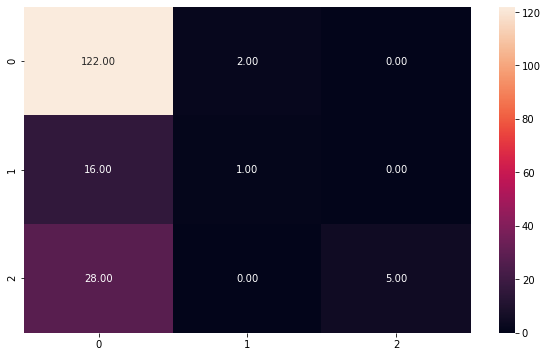

In [17]:
logisticR_accuracy = evaluate_metrics(logisticR_preds, y_test, "Logistic Regression Classifier", logisticR_time)

In [18]:
# Random Forest Algorithm

RandomForest_model = RandomForestClassifier()
RandomForest_start = time.time()
RandomForest_model.fit(x_train_vector, y_train)
RandomForest_stop = time.time()
RandomForest_time = (RandomForest_stop - RandomForest_start)
RandomForest_preds = RandomForest_model.predict(x_test_vector)

Model Type :  Random Forest Classifier

Accuracy :  0.75

Training Time :  0.41 s

               precision    recall  f1-score   support

    negative       0.74      0.99      0.85       124
     neutral       0.67      0.12      0.20        17
    positive       1.00      0.15      0.26        33

    accuracy                           0.75       174
   macro avg       0.80      0.42      0.44       174
weighted avg       0.78      0.75      0.67       174



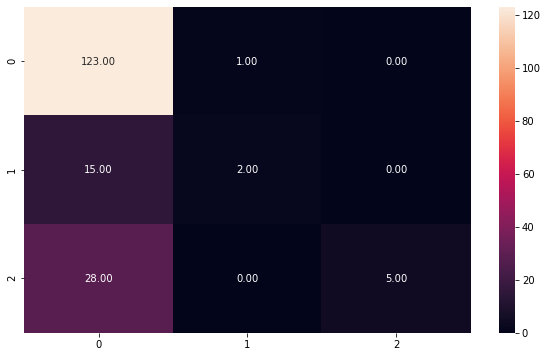

In [19]:
RandomForest_accuracy = evaluate_metrics(RandomForest_preds, y_test, "Random Forest Classifier", RandomForest_time)

In [20]:
# Decision Tree Algorithm

DecisionTree_model = DecisionTreeClassifier(max_depth=20,random_state=0)
DecisionTree_start = time.time()
DecisionTree_model.fit(x_train_vector, y_train)
DecisionTree_stop = time.time()
DecisionTree_time = (DecisionTree_stop - DecisionTree_start)
DecisionTree_pred = DecisionTree_model.predict(x_test_vector)

Model Type :  DecisionTree Classifier

Accuracy :  0.76

Training Time :  0.02 s

               precision    recall  f1-score   support

    negative       0.83      0.93      0.87       124
     neutral       0.47      0.47      0.47        17
    positive       0.56      0.30      0.39        33

    accuracy                           0.76       174
   macro avg       0.62      0.57      0.58       174
weighted avg       0.74      0.76      0.74       174



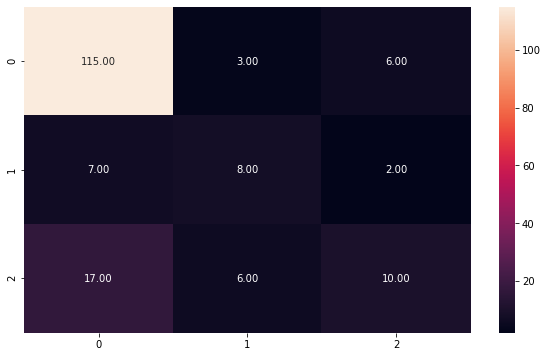

In [21]:
DecisionTree_accuracy = evaluate_metrics(DecisionTree_pred, y_test, "DecisionTree Classifier", DecisionTree_time)

In [22]:
# Support Vector Machine Algorithm (Linear SVC classifier)

svm_model = svm.SVC(kernel='linear')
svm_start = time.time()
svm_model.fit(x_train_vector, y_train)
svm_stop = time.time()
svm_time = (svm_stop - svm_start)
svm_preds = svm_model.predict(x_test_vector)

Model Type :  Support Vector Machine

Accuracy :  0.76

Training Time :  0.07 s

               precision    recall  f1-score   support

    negative       0.75      0.99      0.85       124
     neutral       0.83      0.29      0.43        17
    positive       1.00      0.12      0.22        33

    accuracy                           0.76       174
   macro avg       0.86      0.47      0.50       174
weighted avg       0.81      0.76      0.69       174



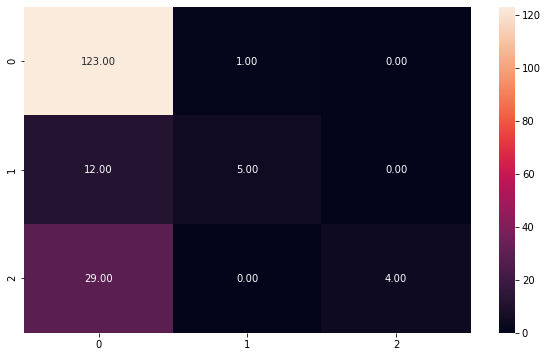

In [23]:
svm_accuracy = evaluate_metrics(svm_preds, y_test, "Support Vector Machine", svm_time)

In [24]:
# Multinomial Naive Bayes Algorithm

MultinomialNB_model = MultinomialNB()
MultinomialNB_start = time.time()
MultinomialNB_model.fit(x_train_vector, y_train)
MultinomialNB_stop = time.time()
MultinomialNB_time = (MultinomialNB_stop - MultinomialNB_start)
MultinomialNB_preds = MultinomialNB_model.predict(x_test_vector)

Model Type :  Multinomial NB Classifier

Accuracy :  0.71

Training Time :  0.00 s

               precision    recall  f1-score   support

    negative       0.71      1.00      0.83       124
     neutral       0.00      0.00      0.00        17
    positive       0.00      0.00      0.00        33

    accuracy                           0.71       174
   macro avg       0.24      0.33      0.28       174
weighted avg       0.51      0.71      0.59       174



/Users/sachinim/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


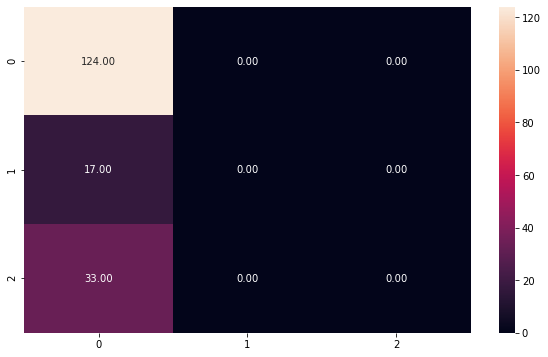

In [25]:
MultinomialNB_accuracy = evaluate_metrics(MultinomialNB_preds, y_test, "Multinomial NB Classifier", MultinomialNB_time)

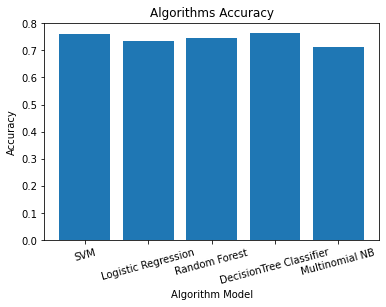

In [26]:
# Graph view of Accuracy

x = ["SVM","Logistic Regression","Random Forest", "DecisionTree Classifier", "Multinomial NB"]
y = [svm_accuracy,logisticR_accuracy,RandomForest_accuracy,DecisionTree_accuracy, MultinomialNB_accuracy]

plt.bar(x=x, height=y)
plt.title("Algorithms Accuracy")
plt.ylabel("Accuracy")
plt.xticks(rotation=15)
plt.xlabel("Algorithm Model")

plt.show()

In [27]:
#save tfidf
with open("tfidf.pkl", 'wb') as file:
    pickle.dump(tfidf_vectorizer, file)

In [28]:
#save model
with open("model.pkl", 'wb') as file:
    pickle.dump(svm_model, file)

In [29]:
########### Load and get Predictions - Should goes to the backend 

with open("model.pkl", 'rb') as file:
    model = pickle.load(file)
    
with open("tfidf.pkl", 'rb') as file:
    tfidf = pickle.load(file)